## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import os
import random

import numpy as np
import pandas as pd
from celluloid import Camera
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

from dataloader import loader
from evaluator import compute_threshold, evaluate

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2023-03-25 00:15:25.465876: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

In [2]:
df_train, df_test, df_test_label = loader(dataset="SMAP")
print(df_train.shape)

(135183, 25)


## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

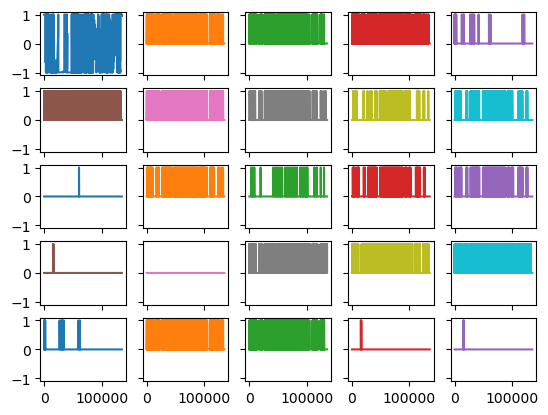

In [3]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
df_train.plot(legend=False, ax=ax, subplots=True)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

  0%|          | 0/25 [00:00<?, ?it/s]

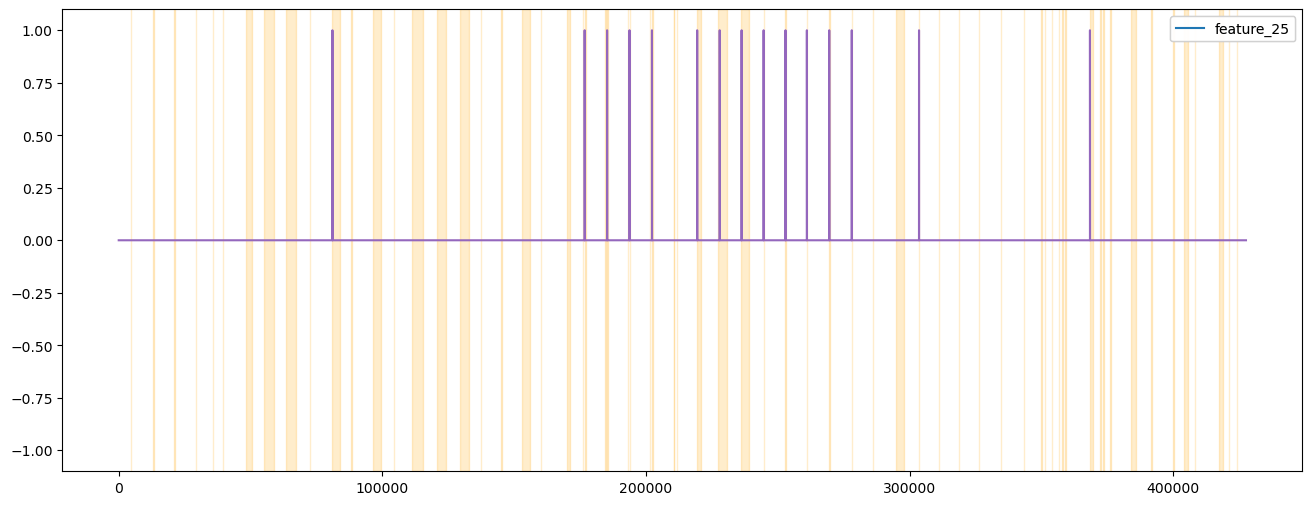

In [4]:
def plot_sensor(df_test, df_test_label, save_path="./SMD.gif"):
    fig = plt.figure(figsize=(16, 6))
    ## 에니메이션 만들기
    camera = Camera(fig)
    ax = fig.add_subplot(111)

    ## 불량 구간 탐색 데이터
    labels = df_test_label["label"].values.tolist()
    idxs = df_test.index

    for var_name in tqdm([item for item in df_test.columns if "feature" in item]):
        ## 센서별로 사진 찍기
        df_test[var_name].plot(ax=ax)
        ax.legend([var_name], loc="upper right")

        ## 고장구간 표시
        temp_start = idxs[0]
        temp_date = idxs[0]
        temp_label = labels[0]

        for xc, value in zip(idxs, labels):
            if temp_label != value:
                if temp_label == True:
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
                temp_start = xc
                temp_label = value
            temp_date = xc

        if temp_label == True:
            ax.axvspan(temp_start, xc, alpha=0.2, color="orange")
        ## 카메라 찍기
        camera.snap()

    animation = camera.animate(500, blit=True)
    # .gif 파일로 저장하면 끝!
    animation.save(save_path, dpi=100, savefig_kwargs={"pad_inches": "tight"})


plot_sensor(df_test, df_test_label)

## Prepare training & test data


In [5]:
# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
df_test_value = pd.DataFrame(scaler.transform(df_test))
print("Number of training samples:", len(df_training_value))
print("Number of test samples:", len(df_test_value))

Number of training samples: 135183
Number of test samples: 427617


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [6]:
TIME_STEPS = 100


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Training input shape:  (135084, 100, 25)
Test input shape:  (427518, 100, 25)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [7]:
model = keras.Sequential(
    [
        layers.InputLayer((x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=x_train.shape[2], kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 32)            5632      
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 100, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 25)           5

2023-03-25 00:15:45.245628: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-25 00:15:45.279662: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-03-25 00:15:45.279709: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-25 00:15:45.282635: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-25 00:15:45.282714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-25 00:15:45.283462: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [8]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

2023-03-25 00:15:49.008538: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-25 00:15:49.028497: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-03-25 00:15:49.541952: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-25 00:15:50.706579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-25 00:15:53.125556: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-25 00:15:53.125597: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-03-25 00:15:53.126175: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-25 00:15:53.126216: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-25 00:15:53.189873: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

845/845 [==============================] - 21s 16ms/step - loss: 0.5631 - val_loss: 0.1129
Epoch 2/50
845/845 [==============================] - 11s 13ms/step - loss: 0.3137 - val_loss: 0.0778
Epoch 3/50
845/845 [==============================] - 11s 13ms/step - loss: 0.2476 - val_loss: 0.0664
Epoch 4/50
845/845 [==============================] - 12s 14ms/step - loss: 0.2123 - val_loss: 0.0591
Epoch 5/50
845/845 [==============================] - 12s 14ms/step - loss: 0.1854 - val_loss: 0.0514
Epoch 6/50
845/845 [==============================] - 12s 14ms/step - loss: 0.1678 - val_loss: 0.0465
Epoch 7/50
845/845 [==============================] - 12s 14ms/step - loss: 0.1505 - val_loss: 0.0427
Epoch 8/50
845/845 [==============================] - 10s 12ms/step - loss: 0.1403 - val_loss: 0.0398
Epoch 9/50
845/845 [==============================] - 12s 14ms/step - loss: 0.1282 - val_loss: 0.0369
Epoch 10/50
845/845 [==============================] - 12s 14ms/step - loss: 0.1222 - val_los

Let's plot training and validation loss to see how the training went.

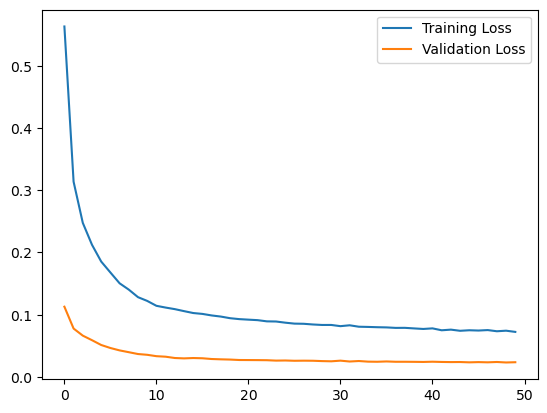

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [10]:
# Get prediction of train data
x_train_pred = model.predict(x_train)
print("Predict train data done")

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print("Predict test data done")

Predict train data done
Predict test data done


In [11]:
thresholds = {
    "abs_mean": compute_threshold(x_train, x_train_pred, option="abs_mean"),
    "abs_median": compute_threshold(x_train, x_train_pred, option="abs_median"),
    "abs_max": compute_threshold(x_train, x_train_pred, option="abs_max"),
    "square_mean": compute_threshold(x_train, x_train_pred, option="square_mean"),
    "square_median": compute_threshold(x_train, x_train_pred, option="square_median"),
    "rank": compute_threshold(x_train, x_train_pred, option="rank", label=df_test_label["label"]),
}
print(f'abs mean threshold: {thresholds["abs_mean"]:.3f}')
print(f'abs median threshold: {thresholds["abs_median"]:.3f}')
print(f'abs max threshold: {thresholds["abs_max"]:.3f}')
print(f'square mean threshold: {thresholds["square_mean"]:.3f}')
print(f'square median threshold: {thresholds["square_median"]:.3f}')
print(f'rank threshold: {thresholds["rank"]:.3f}')


# Detect all the samples which are anomalies.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

abs mean threshold: 0.719
abs median threshold: 0.593
abs max threshold: 8.704
square mean threshold: 0.909
square median threshold: 0.314
rank threshold: 0.759


threshold: 0.719


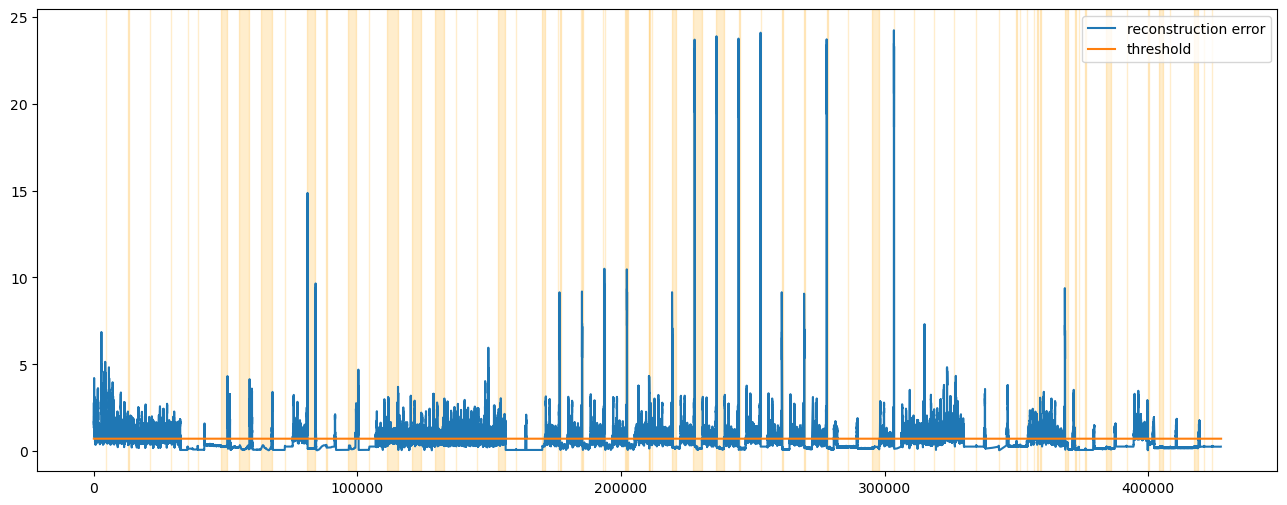

In [12]:
# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = thresholds["abs_mean"]
print(f"threshold: {threshold:.3f}")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label["label"].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold] * len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

## Predict & Evaluation


## #1 if any included time step has anomalies => abnormal

In [13]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["square_median"]
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

test_pred = np.zeros(len(df_test))
test_label = df_test_label["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  236261
Number of anomalous samples:  251820
accuracy: 39.15%
precision: 9.19%
recall: 42.32%
f1: 15.11%


## #2 If half of included time steps has anomaly => abnormal

In [14]:
# data i is an anomaly if ratio of anomalies sequences/involved total sequences >= 0.5
anomalies = np.sum(test_mae_loss, axis=1) > thresholds["square_median"]
test_anomalies = np.zeros(len(df_test))
test_seqs = np.zeros(len(df_test))
test_label = df_test_label["label"]
print("Number of anomaly samples: ", np.sum(anomalies))

for idx, anomaly in enumerate(anomalies):
    test_seqs[idx : min(idx + TIME_STEPS, len(df_test))] += 1
    if anomaly:
        test_anomalies[idx : min(idx + TIME_STEPS, len(df_test))] += 1
test_pred_ratio = np.divide(test_anomalies, test_seqs)
test_pred = test_pred_ratio >= 0.5
print("Number of anomalous samples: ", sum(test_pred))


accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  236261
Number of anomalous samples:  238117
accuracy: 41.25%
precision: 8.73%
recall: 38.02%
f1: 14.20%


In [15]:
idx = 4690
evaluation_array = [
    (test_seqs - test_anomalies)[idx : idx + 400],
    test_anomalies[idx : idx + 400],
    test_seqs[idx : idx + 400],
    test_pred_ratio[idx : idx + 400],
    test_pred[idx : idx + 400],
    df_test_label["label"][idx : idx + 400],
]

df = pd.DataFrame(evaluation_array, dtype=float)
df.index = ["Normal", "Anomaly", "#Seq", "Pred(%)", "Pred", "GT"]
df.style.background_gradient(cmap="summer", axis=1)

### #3 we could find the threshold with highest f1 score by calculating all cases 


In [16]:
from evaluator import evaluate

label = create_sequences(df_test_label["label"], TIME_STEPS)
print(label.shape)
scores = evaluate(x_test, x_test_pred, label, n=10, scoring="abs_mean")

(427518, 100)


In [17]:
# print("f1:",np.max(scores['f1']))
idx = np.argmax(scores["f1"])

print(f"threshold: {scores['thresholds'][idx]}")
print(f"precision: {scores['precision'][idx]*100:.2f}%")
print(f"recall: {scores['recall'][idx]*100:.2f}%")
print(f"f1: {scores['f1'][idx]*100:.2f}%")

threshold: 0.0
precision: 14.35%
recall: 100.00%
f1: 25.09%
